In [137]:
import pandas as pd
import networkx as nx
import numpy as np 
from node2vec import Node2Vec
from collections import defaultdict
from matplotlib import pyplot as plt

In [210]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, multilabel_confusion_matrix
from sklearn.multiclass import OneVsRestClassifier

In [160]:
network = pd.read_csv('data/bio-pathways-network.csv')
graph = nx.from_pandas_edgelist(network, 'Gene ID 1', 'Gene ID 2')

In [6]:
node2vec = Node2Vec(graph, workers=4)

Computing transition probabilities: 100%|██████████| 21557/21557 [07:31<00:00, 47.75it/s] 


In [8]:
n2v_model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [10]:
# Save embeddings for later use
n2v_model.wv.save_word2vec_format('node2vec_embedding.pt')

# Save model for later use
n2v_model.save('node2vec_model.pt')

In [15]:
n2v_model.wv.most_similar('2')

[('348', 0.7114304304122925),
 ('1558', 0.6682052612304688),
 ('22983', 0.6370899677276611),
 ('1562', 0.6319289207458496),
 ('1990', 0.6176955103874207),
 ('124912', 0.6062756776809692),
 ('26085', 0.6044849753379822),
 ('140545', 0.600368857383728),
 ('24138', 0.5945776104927063),
 ('1510', 0.5849873423576355)]

In [21]:
len(n2v_model.wv.vocab)

21557

In [3]:
import stellargraph as sg
import tensorflow as tf

In [5]:
G = sg.StellarGraph.from_networkx(graph)

In [6]:
rw = sg.data.BiasedRandomWalk(G)

walks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=100,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
)
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 215570


In [7]:
from gensim.models import Word2Vec

str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(str_walks, size=128, window=5, min_count=0, sg=1, workers=8, iter=1)

In [14]:
pd.read_csv('data/all-proteins.csv', index_col=0)

inherited metabolic disorder  integumentary system disease  \
3295                                  1                             0   
5189                                  1                             0   
5190                                  1                             0   
5192                                  1                             0   
5193                                  1                             0   
...                                 ...                           ...   
19400                                 0                             0   
81918                                 0                             0   
139378                                0                             0   
18744                                 0                             0   
100360522                             0                             0   

           urinary system disease  nervous system disease  \
3295                            0                       1   
5189                            0                       1   
5190                            0                       0   
5192                            0                       0   
5193                            0                       0   
...                           ...                     ...   
19400                           0                       0   
81918                           0                       0   
139378                          0                       0   
18744                           0                       0   
100360522                       0                       0   

           gastrointestinal system disease  substance-related disorder  \
3295                                     0                           0   
5189                                     0                           0   
5190                                     0                           0   
5192                                     0                           0   
5193                                     0                           0   
...                                    ...                         ...   
19400                                    0                           0   
81918                                    0                           0   
139378                                   0                           0   
18744                                    0                           0   
100360522                                0                           0   

           immune system disease  musculoskeletal system disease  \
3295                           0                               0   
5189                           0                               0   
5190                           0                               0   
5192                           0                               0   
5193                           0                               0   
...                          ...                             ...   
19400                          0                               0   
81918                          0                               0   
139378                         0                               0   
18744                          0                               0   
100360522                      0                               0   

           psoriatic arthritis  cancer  ...  chromosomal disease  hypospadias  \
3295                         0       0  ...                    0            0   
5189                         0       0  ...                    0            0   
5190                         0       0  ...                    0            0   
5192                         0       0  ...                    0            0   
5193                         0       0  ...                    0            0   
...                        ...     ...  ...                  ...          ...   
19400                        0       0  ...                    0            0   
81918                        0       0  ...    

In [31]:
node_subject = pd.read_csv('data/binary-classes.csv', index_col=0)
diseased = node_subject.iloc[:,0]

In [193]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = diseased[[int(node_id) for node_id in node_ids]]
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

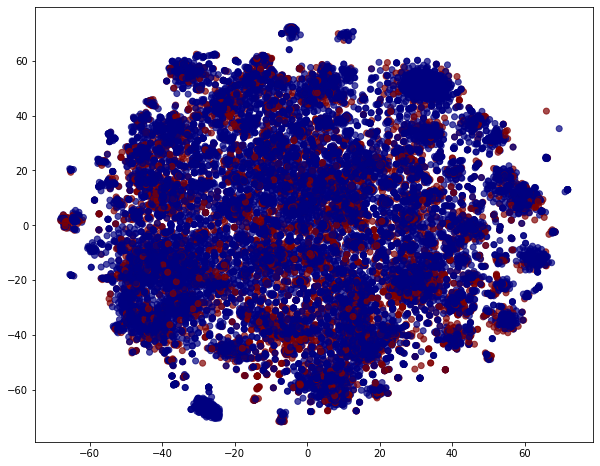

In [41]:
# draw the points
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)

Binary Classification with Logistic Regression on Node2Vec Embeddings

In [171]:
# X will hold the 128-dimensional input features
X = node_embeddings
# y holds the corresponding target values
y = np.array(node_targets)

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, test_size=None)
print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (2155, 128)
 y_train = (2155,)
 X_test = (19402, 128)
 y_test = (19402,)


In [173]:
clf = LogisticRegressionCV(
    Cs=10, cv=10, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=300
)
clf.fit(X_train, y_train)

LogisticRegressionCV(cv=10, max_iter=300, multi_class='ovr', scoring='accuracy',
                     verbose=False)

In [177]:
y_pred = clf.predict(X_test)
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n           0       0.77      0.99      0.86     14700\n           1       0.65      0.07      0.13      4702\n\n    accuracy                           0.77     19402\n   macro avg       0.71      0.53      0.50     19402\nweighted avg       0.74      0.77      0.69     19402\n'

In [183]:
confusion_matrix(y_test, y_pred, normalize='true')

array([[0.98761905, 0.01238095],
       [0.9289664 , 0.0710336 ]])

Multiclass Classification with LogisticRegression on node2vec embeddings

In [81]:
multi_diseases = pd.read_csv('data/all-proteins.csv', index_col=0)
multi_diseases

inherited metabolic disorder  integumentary system disease  \
3295                                  1                             0   
5189                                  1                             0   
5190                                  1                             0   
5192                                  1                             0   
5193                                  1                             0   
...                                 ...                           ...   
19400                                 0                             0   
81918                                 0                             0   
139378                                0                             0   
18744                                 0                             0   
100360522                             0                             0   

           urinary system disease  nervous system disease  \
3295                            0                       1   
5189                            0                       1   
5190                            0                       0   
5192                            0                       0   
5193                            0                       0   
...                           ...                     ...   
19400                           0                       0   
81918                           0                       0   
139378                          0                       0   
18744                           0                       0   
100360522                       0                       0   

           gastrointestinal system disease  substance-related disorder  \
3295                                     0                           0   
5189                                     0                           0   
5190                                     0                           0   
5192                                     0                           0   
5193                                     0                           0   
...                                    ...                         ...   
19400                                    0                           0   
81918                                    0                           0   
139378                                   0                           0   
18744                                    0                           0   
100360522                                0                           0   

           immune system disease  musculoskeletal system disease  \
3295                           0                               0   
5189                           0                               0   
5190                           0                               0   
5192                           0                               0   
5193                           0                               0   
...                          ...                             ...   
19400                          0                               0   
81918                          0                               0   
139378                         0                               0   
18744                          0                               0   
100360522                      0                               0   

           psoriatic arthritis  cancer  ...  chromosomal disease  hypospadias  \
3295                         0       0  ...                    0            0   
5189                         0       0  ...                    0            0   
5190                         0       0  ...                    0            0   
5192                         0       0  ...                    0            0   
5193                         0       0  ...                    0            0   
...                        ...     ...  ...                  ...          ...   
19400                        0       0  ...                    0            0   
81918                        0       0  ...    

In [184]:
multi_only_diseases = pd.read_csv('data/diseased-proteins.csv', index_col=0)

In [215]:
embedding_set = set(node_ids)
drop_rows = []
for n in multi_diseases.index:
    if str(n) not in embedding_set:
        drop_rows.append(n)
new = multi_diseases.drop(drop_rows)

In [216]:
y = new.values

In [217]:
new

inherited metabolic disorder  integumentary system disease  \
3295                                  1                             0   
5189                                  1                             0   
5190                                  1                             0   
5192                                  1                             0   
5193                                  1                             0   
...                                 ...                           ...   
19400                                 0                             0   
81918                                 0                             0   
139378                                0                             0   
18744                                 0                             0   
100360522                             0                             0   

           urinary system disease  nervous system disease  \
3295                            0                       1   
5189                            0                       1   
5190                            0                       0   
5192                            0                       0   
5193                            0                       0   
...                           ...                     ...   
19400                           0                       0   
81918                           0                       0   
139378                          0                       0   
18744                           0                       0   
100360522                       0                       0   

           gastrointestinal system disease  substance-related disorder  \
3295                                     0                           0   
5189                                     0                           0   
5190                                     0                           0   
5192                                     0                           0   
5193                                     0                           0   
...                                    ...                         ...   
19400                                    0                           0   
81918                                    0                           0   
139378                                   0                           0   
18744                                    0                           0   
100360522                                0                           0   

           immune system disease  musculoskeletal system disease  \
3295                           0                               0   
5189                           0                               0   
5190                           0                               0   
5192                           0                               0   
5193                           0                               0   
...                          ...                             ...   
19400                          0                               0   
81918                          0                               0   
139378                         0                               0   
18744                          0                               0   
100360522                      0                               0   

           psoriatic arthritis  cancer  ...  chromosomal disease  hypospadias  \
3295                         0       0  ...                    0            0   
5189                         0       0  ...                    0            0   
5190                         0       0  ...                    0            0   
5192                         0       0  ...                    0            0   
5193                         0       0  ...                    0            0   
...                        ...     ...  ...                  ...          ...   
19400                        0       0  ...                    0            0   
81918                        0       0  ...    

In [218]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, test_size=None)
print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (2155, 128)
 y_train = (2155, 30)
 X_test = (19402, 128)
 y_test = (19402, 30)


In [219]:
mclf = OneVsRestClassifier(RidgeClassifierCV())
mclf.fit(X_train,y_train)

OneVsRestClassifier(estimator=RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ])))

In [220]:
y_pred = mclf.predict(X_test)

In [221]:
y_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [222]:
multilabel_confusion_matrix(y_test, y_pred)

array([[[19235,     0],
        [  167,     0]],

       [[19107,     0],
        [  295,     0]],

       [[18826,     0],
        [  576,     0]],

       [[18346,     0],
        [ 1055,     1]],

       [[19051,     0],
        [  351,     0]],

       [[19297,     0],
        [  105,     0]],

       [[19100,     0],
        [  302,     0]],

       [[18981,     0],
        [  421,     0]],

       [[19389,     0],
        [   13,     0]],

       [[17443,    21],
        [ 1917,    21]],

       [[19373,     0],
        [   29,     0]],

       [[19247,     0],
        [  155,     0]],

       [[18678,     0],
        [  724,     0]],

       [[19089,     0],
        [  313,     0]],

       [[19325,     0],
        [   77,     0]],

       [[18931,     0],
        [  471,     0]],

       [[19372,     0],
        [   30,     0]],

       [[19293,     0],
        [  109,     0]],

       [[19297,     0],
        [  105,     0]],

       [[19391,     0],
        [   11,     0]],



In [223]:
accuracy_score(y_test, y_pred)

0.7567776517884754

Trying only diseased nodes to prevent class imbalance

In [227]:
dis_graph = nx.read_gml('networks/diseased-ppi')

In [228]:
G = sg.StellarGraph.from_networkx(dis_graph)
rw = sg.data.BiasedRandomWalk(G)

dwalks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=100,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
)
print("Number of random walks: {}".format(len(dwalks)))

Number of random walks: 50290


In [229]:
from gensim.models import Word2Vec

dstr_walks = [[str(n) for n in walk] for walk in dwalks]
dis_model = Word2Vec(dstr_walks, size=128, window=5, min_count=0, sg=1, workers=8, iter=1)

In [230]:
# Retrieve node embeddings and corresponding subjects
dnode_ids = dis_model.wv.index2word  # list of node IDs
dis_node_embeddings = (
    dis_model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality

In [231]:
multi_only_diseases = pd.read_csv('data/diseased-proteins.csv', index_col=0)

In [237]:
embedding_set = set(dnode_ids)
drop_rows = []
for n in multi_only_diseases.index:
    if str(n) not in embedding_set:
        drop_rows.append(n)
new = multi_only_diseases.drop(drop_rows)

In [238]:
X = dis_node_embeddings
y = new.values

In [239]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, test_size=None)
print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (502, 128)
 y_train = (502, 30)
 X_test = (4527, 128)
 y_test = (4527, 30)


In [246]:
mclf = OneVsRestClassifier(RidgeClassifierCV())
mclf.fit(X_train,y_train)

OneVsRestClassifier(estimator=RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ])))

In [247]:
y_pred = mclf.predict(X_test)

In [248]:
multilabel_confusion_matrix(y_test, y_pred)

array([[[4361,    0],
        [ 166,    0]],

       [[4245,    0],
        [ 282,    0]],

       [[3960,    3],
        [ 563,    1]],

       [[3444,   66],
        [1002,   15]],

       [[4171,    0],
        [ 356,    0]],

       [[4434,    0],
        [  93,    0]],

       [[4219,    0],
        [ 308,    0]],

       [[4102,    1],
        [ 424,    0]],

       [[4515,    0],
        [  12,    0]],

       [[2032,  621],
        [1409,  465]],

       [[4498,    0],
        [  29,    0]],

       [[4378,    0],
        [ 149,    0]],

       [[3797,    4],
        [ 723,    3]],

       [[4214,    0],
        [ 313,    0]],

       [[4454,    0],
        [  73,    0]],

       [[4069,    2],
        [ 456,    0]],

       [[4500,    0],
        [  27,    0]],

       [[4424,    0],
        [ 103,    0]],

       [[4431,    0],
        [  96,    0]],

       [[4515,    0],
        [  12,    0]],

       [[4431,    0],
        [  96,    0]],

       [[4514,    0],
        [  1

In [257]:
print('samples: ', f1_score(y_test, y_pred, average='samples'))
print('macro:',f1_score(y_test, y_pred, average='micro'))
print('micro:',f1_score(y_test, y_pred, average='macro'))
print('weighted:',f1_score(y_test, y_pred, average='weighted'))

samples:  0.07447109562749059
macro: 0.1048526863084922
micro: 0.011773941973421567
weighted: 0.07756875450344439


In [258]:
# Still only guessing one side :/